<a href="https://colab.research.google.com/github/YvixMiHo/TensorFlow_Developer_Skills/blob/main/FoodClassification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Depenedencies

In [1]:
import os
import zipfile
import datetime
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator


##1.a Helper Functions

In [2]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True


In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log to: {log_dir}")
  return tensorboard_callback

In [4]:
def create_model(model_url, num_classes):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,))
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')

  ])

  return model

In [21]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.title("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.title("epochs")
  plt.legend()


##1.b Defines

In [5]:
IMAGE_SHAPE = (244,224)
BATCH_SIZE = 32
NUMBER_CLASSES = 10
EPOCHS = 5

# 2. Load Enviornment / Data set

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-04 14:20:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 142.250.4.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2022-07-04 14:20:47 (159 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficentnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

## 2.a Make sense of the data, use confusion matrix if necessary

In [9]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directorties and {len(filenames)} images in '{dirpath}'.")

There are 2 directorties and 0 images in '10_food_classes_10_percent'.
There are 10 directorties and 0 images in '10_food_classes_10_percent/train'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directorties and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directorties and 75 images in '10_food_classes_10

In [10]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data = ImageDataGenerator(rescale = 1/255.0)
test_data = ImageDataGenerator(rescale = 1/255.0)

print("training images:")
train_data_imgs = train_data.flow_from_directory(train_dir,
                                                 target_size = IMAGE_SHAPE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = "categorical")
print("testing images:")
test_data_imgs = test_data.flow_from_directory(test_dir,
                                                 target_size = IMAGE_SHAPE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = "categorical")

training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


##2.b Feature extraction model
set up callback to allow other code to run while training model
- create a tensorboard callback

In [11]:
resnet_model = create_model(resnet_url,num_classes=train_data_imgs.num_classes)

In [23]:
efficentnet_model = create_model(efficentnet_url,num_classes=train_data_imgs.num_classes)

In [12]:
resnet_model.compile(loss = losses.CategoricalCrossentropy(),
                     optimizer = optimizers.Adam(lr = 0.001),
                     metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
efficentnet_model.compile(loss = losses.CategoricalCrossentropy(),
                     optimizer = optimizers.Adam(lr = 0.001),
                     metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
efficentnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [14]:
resnet_history = resnet_model.fit(train_data_imgs,
                                  epochs = EPOCHS,
                                  steps_per_epoch=len(train_data_imgs),
                                  validation_data=test_data_imgs,
                                  callbacks = [create_tensorboard_callback(
                                      dir_name = "tensorflow_hub",
                                      experiment_name = "resnet50V2"
                                  )])

saving tensorboard log to: tensorflow_hub/resnet50V2/20220704-142101
Epoch 1/5
24/24 [==============================] - 33s 788ms/step - loss: 1.7720 - accuracy: 0.4093 - val_loss: 1.1642 - val_accuracy: 0.6372
Epoch 2/5
24/24 [==============================] - 17s 738ms/step - loss: 0.8529 - accuracy: 0.7520 - val_loss: 0.8330 - val_accuracy: 0.7436
Epoch 3/5
24/24 [==============================] - 16s 701ms/step - loss: 0.5999 - accuracy: 0.8413 - val_loss: 0.7443 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 17s 709ms/step - loss: 0.4716 - accuracy: 0.8680 - val_loss: 0.6967 - val_accuracy: 0.7700
Epoch 5/5
24/24 [==============================] - 17s 710ms/step - loss: 0.3758 - accuracy: 0.9093 - val_loss: 0.6535 - val_accuracy: 0.7888


In [29]:
efficentnethisotry = efficentnet_model.fit(train_data_imgs,
                                  epochs = EPOCHS,
                                  steps_per_epoch=len(train_data_imgs),
                                  validation_data=test_data_imgs,
                                  callbacks = [create_tensorboard_callback(
                                      dir_name = "tensorflow_hub",
                                      experiment_name = "Efficentnetb0"
                                  )])

saving tensorboard log to: tensorflow_hub/Efficentnetb0/20220704-143243
Epoch 1/5
24/24 [==============================] - 26s 740ms/step - loss: 1.8580 - accuracy: 0.4053 - val_loss: 1.2831 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 16s 695ms/step - loss: 1.0661 - accuracy: 0.7720 - val_loss: 0.8599 - val_accuracy: 0.8296
Epoch 3/5
24/24 [==============================] - 16s 674ms/step - loss: 0.7593 - accuracy: 0.8413 - val_loss: 0.6922 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 16s 677ms/step - loss: 0.6138 - accuracy: 0.8667 - val_loss: 0.6056 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 15s 664ms/step - loss: 0.5201 - accuracy: 0.8840 - val_loss: 0.5550 - val_accuracy: 0.8648


## 2.c Validate data shape

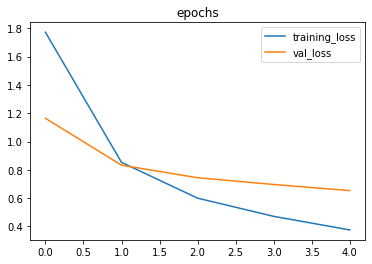

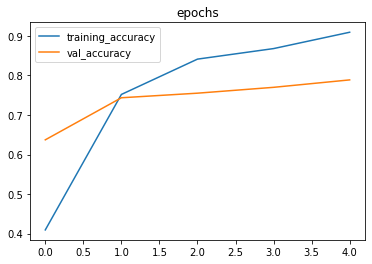

In [22]:
plot_loss_curves(resnet_history)

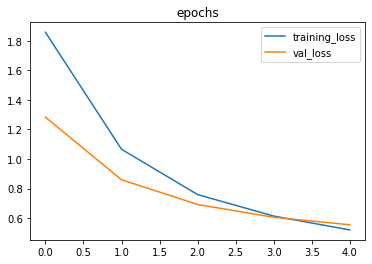

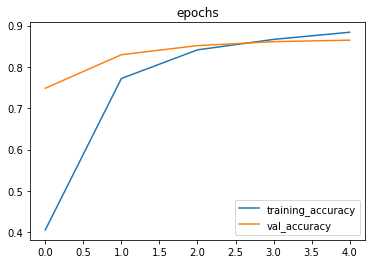

In [30]:
plot_loss_curves(efficentnethisotry)

## 2.d preprocess data

# 3. Create, Train and Fit model

# 4. Evaluate the model